## Phishing Email 的 NER

In [37]:
import stanza
from stanza.server import CoreNLPClient

import os
import pandas as pd

import nltk
from nltk.parse import CoreNLPParser
from nltk.parse.corenlp import *
from nltk.corpus import stopwords

from wordcloud import WordCloud

import re
import matplotlib.pyplot as plt

## 設定 CoreNLP

In [2]:
# stanza.install_corenlp("./stanza_corenlp") # 下載coreNLP模型，預設會在/stanza_corenlp裡面

2024-05-18 12:51:54 WARNING: Directory ./stanza_corenlp already exists. Please install CoreNLP to a new directory.


In [2]:
os.environ['CORENLP_HOME'] = "./stanza_corenlp" # 因為自訂下載路徑，所以要設定環境參數

In [2]:
## 讀取文章
mails_df = pd.read_csv('dataset/Phishing_Email.csv')

In [3]:
# 刪除標點符號/數字/換行符號
mails_df["Email Text"] = mails_df["Email Text"].apply(lambda x: re.sub(r'[^\w\s]','', str(x)))  #只留下英文字母和空格(包含換行符號)
mails_df["Email Text"] = mails_df["Email Text"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格

# 去除空值
mails_df = mails_df[mails_df["Email Text"] != 'empty']

# 把欄位名字變好聽
mails_df = mails_df.rename(columns={"Unnamed: 0":"index"})

mails_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18117 entries, 0 to 18648
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       18117 non-null  int64 
 1   Email Text  18117 non-null  object
 2   Email Type  18117 non-null  object
dtypes: int64(1), object(2)
memory usage: 566.2+ KB


In [4]:
# 只取 Phishing mail
Phishing_mails = mails_df[mails_df["Email Type"] == 'Phishing Email']
Phishing_mails.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6993 entries, 3 to 18645
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       6993 non-null   int64 
 1   Email Text  6993 non-null   object
 2   Email Type  6993 non-null   object
dtypes: int64(1), object(2)
memory usage: 218.5+ KB


In [6]:
def get_nlp_result(df, text_col, id_col):    
    
    print("Starting a server with the Python \"with\" statement...")
    
    start = time.time()

    with CoreNLPClient(
        # annotators = ['tokenize','ssplit', 'pos', 'lemma', 'ner','sentiment','entitymentions'],
        # 只跑 ner 就好
        annotators = ['ner'],
        memory = '32G', endpoint = 'http://localhost:7777' , be_quiet=True, timeout=300000
    ) as client:
        
        token_list = []        
        for index, row in df.iterrows(): # document level  
            print(index)
            # send text into client
            document = client.annotate(row[text_col])                
            # print(f"{'Word':12s}\t{'Lemma':12s}\t{'POS':6s}\t{'NER'}")    
            
             # sentence level
            for i, sent in enumerate(document.sentence):                
                s = ""
                # token level
                for t in sent.token: 
                    s = s + " " + t.word # for sentence                
                    # print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))                
                    # save lemma, pos, ner
                    temp_token = [row[id_col],t.word, t.ner]     
                    token_list.append(temp_token) 


        token_table = pd.DataFrame(data=token_list, 
                            columns=[id_col, 'word', 'ner'])        

        end = time.time()

        print("time costing: {}".format(end - start))
        print("\nThe server should be stopped upon exit from the \"with\" statement.")

        # return token_table, senti_table , mention_table
        return token_table

In [7]:
# 查看 Phishing mail字數，把字數太多的刪掉
lenli = [len(i) for i in Phishing_mails["Email Text"]]
lenli2 = [i for i in Phishing_mails["index"]]

for i, content in enumerate(lenli):
    if lenli[i] > 30000:
        print( "index:", lenli2[i], "length:", lenli[i])

index: 6427 length: 69553
index: 7991 length: 43357
index: 8069 length: 124521
index: 13765 length: 70493
index: 14275 length: 48867


In [8]:
# 把太多字的信去掉
Phishing_mails_new = Phishing_mails[Phishing_mails["index"] != 8069]
Phishing_mails_new = Phishing_mails_new[Phishing_mails_new["index"] != 6427]
Phishing_mails_new = Phishing_mails_new[Phishing_mails_new["index"] != 7991]
Phishing_mails_new = Phishing_mails_new[Phishing_mails_new["index"] != 13765]
Phishing_mails_new = Phishing_mails_new[Phishing_mails_new["index"] != 14275]


In [9]:
Phishing_mails_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6988 entries, 3 to 18645
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       6988 non-null   int64 
 1   Email Text  6988 non-null   object
 2   Email Type  6988 non-null   object
dtypes: int64(1), object(2)
memory usage: 218.4+ KB


## 拆分資料集並跑 ner

In [10]:
# 拆分資料集 不然會跑到斷線
Phishing_mails_1 = Phishing_mails_new[:1000]
Phishing_mails_2 = Phishing_mails_new[1000:2000]
Phishing_mails_3 = Phishing_mails_new[2000:3000]
Phishing_mails_4 = Phishing_mails_new[3000:4000]
Phishing_mails_5 = Phishing_mails_new[4000:5000]
Phishing_mails_6 = Phishing_mails_new[5000:6000]
Phishing_mails_7 = Phishing_mails_new[6000:6988]

In [ ]:
# 跑NER 並把它存成 CSV
tokens_ner1 = get_nlp_result(Phishing_mails_1, 'Email Text','index') # 資料框, 要處理的文字欄位名, id 欄位名
tokens_ner1.to_csv('dataset/Phishing_ner1.csv', encoding = 'utf-8', index = False)
tokens_ner2 = get_nlp_result(Phishing_mails_2, 'Email Text','index') # 資料框, 要處理的文字欄位名, id 欄位名
tokens_ner2.to_csv('dataset/Phishing_ner2.csv', encoding = 'utf-8', index = False)
tokens_ner3 = get_nlp_result(Phishing_mails_3, 'Email Text','index') # 資料框, 要處理的文字欄位名, id 欄位名
tokens_ner3.to_csv('dataset/Phishing_ner3.csv', encoding = 'utf-8', index = False)
tokens_ner4 = get_nlp_result(Phishing_mails_4, 'Email Text','index') # 資料框, 要處理的文字欄位名, id 欄位名
tokens_ner4.to_csv('dataset/Phishing_ner4.csv', encoding = 'utf-8', index = False)
tokens_ner5 = get_nlp_result(Phishing_mails_5, 'Email Text','index') # 資料框, 要處理的文字欄位名, id 欄位名
tokens_ner5.to_csv('dataset/Phishing_ner5.csv', encoding = 'utf-8', index = False)
tokens_ner6 = get_nlp_result(Phishing_mails_6, 'Email Text','index') # 資料框, 要處理的文字欄位名, id 欄位名
tokens_ner6.to_csv('dataset/Phishing_ner6.csv', encoding = 'utf-8', index = False)
tokens_ner7 = get_nlp_result(Phishing_mails_7, 'Email Text','index') # 資料框, 要處理的文字欄位名, id 欄位名
tokens_ner7.to_csv('dataset/Phishing_ner7.csv', encoding = 'utf-8', index = False)

In [34]:
# 將資料集 concat 成一份 CSV
phishing1 = pd.read_csv("dataset/Phishing_ner1.csv")
phishing2 = pd.read_csv("dataset/Phishing_ner2.csv")
phishing3 = pd.read_csv("dataset/Phishing_ner3.csv")
phishing4 = pd.read_csv("dataset/Phishing_ner4.csv")
phishing5 = pd.read_csv("dataset/Phishing_ner5.csv")
phishing6 = pd.read_csv("dataset/Phishing_ner6.csv")
phishing7 = pd.read_csv("dataset/Phishing_ner7.csv")

phishing_new = pd.concat([phishing1, phishing2, phishing3, phishing4, phishing5, phishing6, phishing7], ignore_index=True)
phishing_new.to_csv("dataset/Phishing_ner_all.csv", index=False)

## 從這裡開始！！

完整資料的資料前處裡

前面有一樣的code 只是放到這裡比較方便

In [38]:
## 讀取文章
mails_df = pd.read_csv('dataset/Phishing_Email.csv')

# 刪除標點符號/數字/換行符號
mails_df["Email Text"] = mails_df["Email Text"].apply(lambda x: re.sub(r'[^\w\s]','', str(x)))  #只留下英文字母和空格(包含換行符號)
mails_df["Email Text"] = mails_df["Email Text"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格

# 去除空值
mails_df = mails_df[mails_df["Email Text"] != 'empty']

# 把欄位名字變好聽
mails_df = mails_df.rename(columns={"Unnamed: 0":"index"})

mails_df.info()

# 只取 Phishing mail
Phishing_mails = mails_df[mails_df["Email Type"] == 'Phishing Email']
Phishing_mails.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18117 entries, 0 to 18648
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       18117 non-null  int64 
 1   Email Text  18117 non-null  object
 2   Email Type  18117 non-null  object
dtypes: int64(1), object(2)
memory usage: 566.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 6993 entries, 3 to 18645
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       6993 non-null   int64 
 1   Email Text  6993 non-null   object
 2   Email Type  6993 non-null   object
dtypes: int64(1), object(2)
memory usage: 218.5+ KB


## 讀取NER資料集並分析
O代表非NER的字詞 因此會把O類別刪掉 

In [39]:
Phishing_ner = pd.read_csv("dataset/Phishing_ner_all.csv")
Phishing_ner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768342 entries, 0 to 1768341
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   index   int64 
 1   word    object
 2   ner     object
dtypes: int64(1), object(2)
memory usage: 40.5+ MB


### 去除停用字

In [40]:
# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')
# 使用nltk的stop_words
stops = stopwords.words('english')
# 手動加入停用字
newStops = ['email','com','wa','ect','one','would','could','may','can','de','also','edu','ha']
stops.extend(newStops)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win90\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
Phishing_ner_noStop = Phishing_ner[~Phishing_ner['word'].isin(stops)]
Phishing_ner_noStop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1133636 entries, 0 to 1768341
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   index   1133636 non-null  int64 
 1   word    1133586 non-null  object
 2   ner     1133636 non-null  object
dtypes: int64(1), object(2)
memory usage: 34.6+ MB


In [42]:
# 把O這個ner刪掉
Phishing_ner_noStop = Phishing_ner_noStop[Phishing_ner_noStop['ner'] != 'O']
freq_ner = pd.DataFrame(Phishing_ner_noStop['ner'].value_counts()).reset_index()
freq_ner.head(10)

,ner,count
0,NUMBER,84729
1,DATE,25558
2,DURATION,12750
3,TITLE,8777
4,ORGANIZATION,7405
5,COUNTRY,5533
6,MISC,3541
7,MONEY,3272
8,STATE_OR_PROVINCE,2389
9,PERSON,2300


### NER詞頻

C:\Users\win90\AppData\Local\Temp\ipykernel_3372\3076567002.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


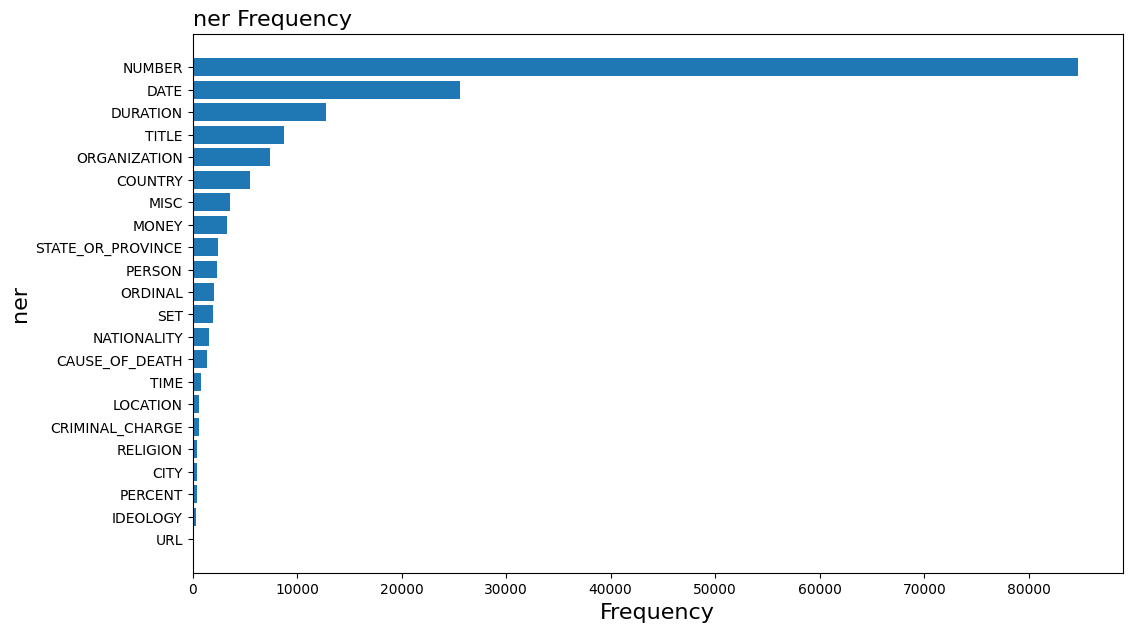

In [43]:
ner = freq_ner['ner']
count = freq_ner['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 16)
ax.set_ylabel('ner', size = 16)
ax.set_xlabel('Frequency', size = 16)
fig.show()

根據 POS 的結果，因為提到大量與 money、free 的內容，因此最多的 NER 為 NUMBER 並沒有很意外，且因為要強調錯過不再 （late），因此會有許多 DATE。

為了正確計算詞頻，將字詞轉小寫存新欄位

In [44]:
Phishing_ner_noStop['word_lower'] = Phishing_ner_noStop['word'].str.lower()
Phishing_ner_noStop.head(5)

,index,word,ner,word_lower
83,3,19009932582,NUMBER,19009932582
92,3,Mailcom,ORGANIZATION,mailcom
99,4,86,NUMBER,86
102,4,seventeen,NUMBER,seventeen
118,4,student,TITLE,student


### 涉及到的組織 ORGANIZATION
+ 透過 CoreNLP 中的 NER 解析出在釣魚文件中所涉及到的組織(ORGANIZATION)

In [45]:
# 篩選ner為country的資料
ner_org = Phishing_ner_noStop.loc[Phishing_ner_noStop['ner'] == 'ORGANIZATION']

# 計算每個地點提到的次數，選出前8個
org_count = ner_org[['word_lower']].groupby(['word_lower'])['word_lower'].count().reset_index(name='count')
org_count = org_count.sort_values(['count'], ascending=False).head(8)
org_count.head(10)

,word_lower,count
1894,us,84
925,inc,71
796,group,68
1230,microsoft,59
994,irish,57
1898,users,57
1116,linux,56
1397,optin,55


C:\Users\win90\AppData\Local\Temp\ipykernel_3372\2426558990.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


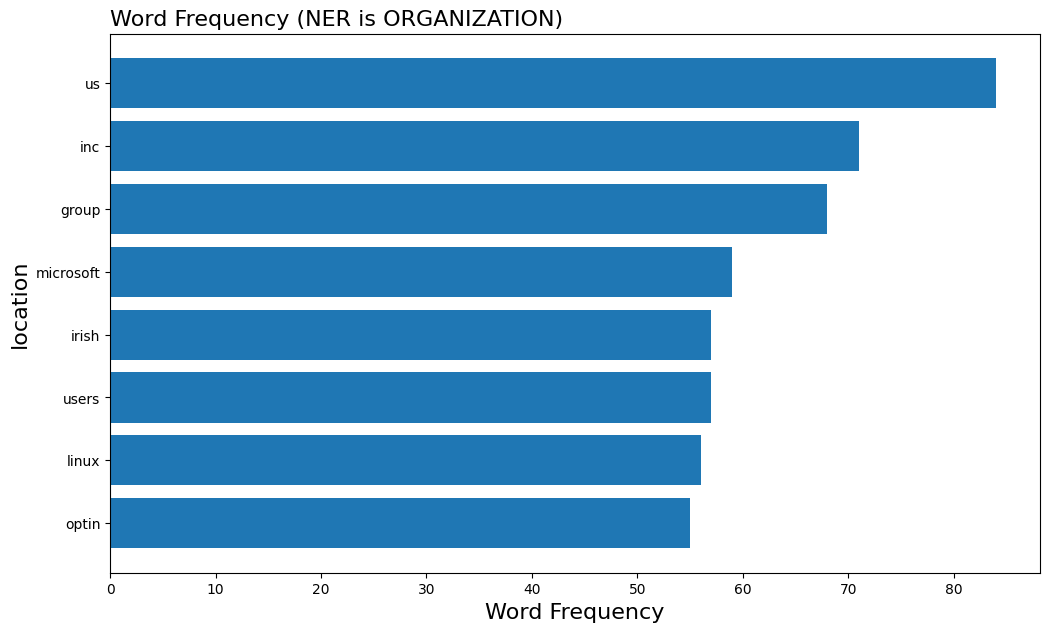

In [46]:
word = org_count['word_lower']
count = org_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 16)
ax.set_ylabel('location', size = 16)
ax.set_xlabel('Word Frequency', size = 16)
fig.show()

結合 POS 和 NER 的結果，發現大多的 Phishing Email 內容的確是以公司的名義，且大多是以知名美國（us）公司或集團名義（microsoft、inc、group），提供收信人關於軟體（linux）的資訊

### 抓取關鍵字，看看相關的章節大致在說甚麼 

In [47]:
# 取關鍵字
keyword_list = ['microsoft']
ids = [i for i in Phishing_ner_noStop[Phishing_ner_noStop['word_lower'].str.contains('|'.join(keyword_list),regex=True, case=False)]["index"]]
df = Phishing_mails[Phishing_mails['index'].isin(ids)].reset_index(drop=True)
print(f"{' '.join(keyword_list)}：{df.shape[0]}個相關郵件")
df.head(10)

microsoft：45個相關郵件


,index,Email Text,Email Type
0,744,intel play me 2 web cam 13 90 play me 2 web...,Phishing Email
1,858,lotto information office of the vice presi...,Phishing Email
2,1062,we have 800 expensive softwares for u to choos...,Phishing Email
3,1231,name get the best softwares for only 15 dkvn...,Phishing Email
4,1993,paydshl get latest softwares 99 savings ayo...,Phishing Email
5,2093,re your needed soffttwares at rock bottom prr...,Phishing Email
6,2315,fwd your needed soffttwares at rock bottom pr...,Phishing Email
7,2450,re we might have just what you need special ...,Phishing Email
8,2777,To avfsfazekashu Attn Marketing Department ...,Phishing Email
9,3130,award winning notification forehigh lottery in...,Phishing Email


發現大多的確是提供軟體的資訊，且結合 POS 分析結果，可能大多與金錢（money）、優惠、免費（free）相關，且應該都包含與時限（DATE）有關的資訊，來強調這是最棒（best）的優惠不要錯過（late）

### 查看特定文章的完整文字

In [48]:
print(df[df['index'] == 744]["Email Text"].values)

['intel play me 2 web cam   13  90 play me 2 web cam usb 1  0  13  90 visit  http    www  computron  me  com for deals  intel play me 2 web cam usb 1  0 intel play me 2 web cam  usb 1  0 compliant interface  includes interactive video games  doubles up as video conferencing camera  compatible with microsoft net meeting   your one stop distributorjebel ali duty free zonedubai  uae  www  computron  me  com for latest clearance sale listing contact our sales department  for further details please send your enquiries to  dealers  emirates  net  aeor contact via www  computron  me  com compaq hewlett packard 3 com dell intel iomega epson aopen creative toshiba apc cisco us robotics microsoft canon intellinet targus viewsonic ibm sony        and lots more    if you have any complaints  suggestions contact  customerservice  computron  me  com tel  971 4 8834464 all prices in u  s  dollars  ex  works  fax  971 4 8834454 jebel ali duty free zone www  computron  me  com prices and availability s